- [Import Libraries](#1)
- [Reading the Dataset](#2)
- [Data Pre-processing](#3)
- [Modeling](#4)
- [Conclusions](#5)
- [References](#6)

# Import Libraries <a id = '1'></a>

In [ ]:
import cv2
import glob
from lxml import etree
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf 
from tensorflow import keras 
from keras.layers import BatchNormalization, Conv2D, Dense,Dropout, Flatten, GlobalAveragePooling2D, MaxPool2D, ReLU
from tensorflow.keras.applications import Xception

import warnings
warnings.filterwarnings("ignore")

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Colab Notebooks - Kaggel/Car License Plate Detection with Xception"
%cd "/content/gdrive/MyDrive/Colab Notebooks - Kaggel/Car License Plate Detection with Xception"

/content/gdrive/MyDrive/Colab Notebooks - Kaggel/Car License Plate Detection with Xception


In [9]:
!kaggle datasets download -d andrewmvd/car-plate-detection

 97% 197M/203M [00:08<00:00, 22.8MB/s]
100% 203M/203M [00:08<00:00, 24.3MB/s]


In [10]:
!unzip \*.zip  && rm *.zip

Archive:  car-plate-detection.zip
  inflating: annotations/Cars0.xml   
  inflating: annotations/Cars1.xml   
  inflating: annotations/Cars10.xml  
  inflating: annotations/Cars100.xml  
  inflating: annotations/Cars101.xml  
  inflating: annotations/Cars102.xml  
  inflating: annotations/Cars103.xml  
  inflating: annotations/Cars104.xml  
  inflating: annotations/Cars105.xml  
  inflating: annotations/Cars106.xml  
  inflating: annotations/Cars107.xml  
  inflating: annotations/Cars108.xml  
  inflating: annotations/Cars109.xml  
  inflating: annotations/Cars11.xml  
  inflating: annotations/Cars110.xml  
  inflating: annotations/Cars111.xml  
  inflating: annotations/Cars112.xml  
  inflating: annotations/Cars113.xml  
  inflating: annotations/Cars114.xml  
  inflating: annotations/Cars115.xml  
  inflating: annotations/Cars116.xml  
  inflating: annotations/Cars117.xml  
  inflating: annotations/Cars118.xml  
  inflating: annotations/Cars119.xml  
  inflating: annotations/Cars12.xm

# Reading the Dataset <a id = '2'></a>

- <a href = 'https://www.kaggle.com/datasets/andrewmvd/car-plate-detection'>Link to the dataset in the Kaggel.</a>

<i>"This dataset contains 433 images with bounding box annotations of the car license plates within the image.
Annotations are provided in the PASCAL VOC format."</i>

In [18]:
img_list = [] 
annot_list = []

for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/Colab Notebooks - Kaggel/Car License Plate Detection with Xception'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]=="png":
            img_list.append(os.path.join(dirname, filename))
        elif os.path.join(dirname, filename)[-3:]=="xml":
            annot_list.append(os.path.join(dirname, filename))
            
img_list.sort()
annot_list.sort()

# Data Pre-processing <a id = '3'></a>

In [21]:
def get_annotation(annotation):
    
    tree = etree.parse(annotation)
    
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
        
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)
        ymin = int(dim.xpath("ymin")[0].text)
        xmax = int(dim.xpath("xmax")[0].text)
        ymax = int(dim.xpath("ymax")[0].text)
        
    return [int(xmax), int(ymax), int(xmin), int(ymin), int(width), int(height)]

annot_coor = []

for annotation in annot_list:
    annot_coor.append(get_annotation(annotation))

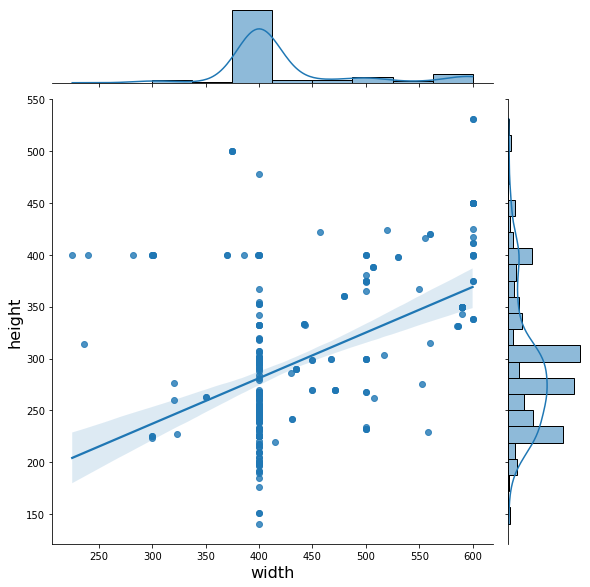

In [22]:
images_width = [i[4] for i in annot_coor]
images_height = [i[5] for i in annot_coor]

j_plot = sns.jointplot(x = images_width, y = images_height, kind = 'reg', height = 8)
j_plot.set_axis_labels('width', 'height', fontsize = 16)

In [23]:
img_width = 400
img_height = 280

In [24]:
X = []

for i in img_list:
    img = cv2.imread(i) 
    img = cv2.resize(img, (img_width, img_height))
    X.append(np.array(img))

X_arr = np.array(X)
print(f'Shape of images(X): {X_arr.shape} (m, height, width, channels)')

Shape of images(X): (433, 280, 400, 3) (m, height, width, channels)


In [25]:
def resize_annotation(annotation):
    
    tree = etree.parse(annotation)
    
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
        
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/img_width)
        ymin = int(dim.xpath("ymin")[0].text)/(height/img_height)
        xmax = int(dim.xpath("xmax")[0].text)/(width/img_width)
        ymax = int(dim.xpath("ymax")[0].text)/(height/img_height)
        
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [26]:
y = []

for annotation in annot_list:
    y.append(resize_annotation(annotation))
    
y_arr = np.array(y)
print(f'Shape of annotations(y): {y_arr.shape} (m, bbox[xmax, ymax, xmin, ymin])')

Shape of annotations(y): (433, 4) (m, bbox[xmax, ymax, xmin, ymin])


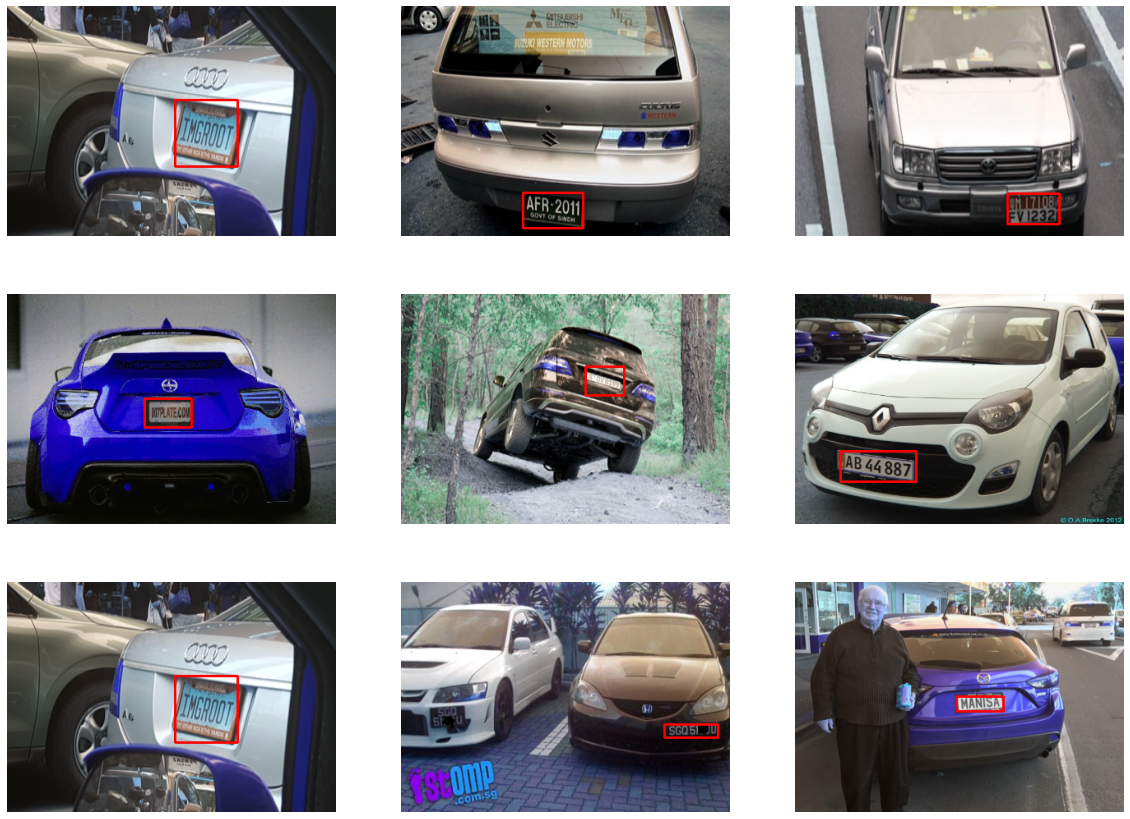

In [27]:
plt.figure(figsize = (20, 15))

for num, i in enumerate(np.random.randint(X_arr.shape[0],size = 9)):
    
    plt.subplot(3, 3, num + 1)
    
    img_rec = cv2.rectangle(
        X_arr[i], #image
        (y_arr[i][0], y_arr[i][1]), #start_point
        (y_arr[i][2], y_arr[i][3]), #end_point
        (255, 0, 0), #color
        2 #thickness
    )
    plt.imshow(img_rec)
    plt.axis('off')

In [28]:
X_arr_norm = X_arr / 255.
y_arr_norm = y_arr / float(img_width)

x_train, x_test, y_train, y_test = train_test_split(X_arr_norm, y_arr_norm, test_size = 0.2)
print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of x_train: (346, 280, 400, 3)
Shape of y_train: (346, 4)
Shape of x_test: (87, 280, 400, 3)
Shape of y_test: (87, 4)


# Modeling <a id = '4'></a>

In [29]:
base_xception = Xception(
    input_shape = (img_height, img_width, 3),
    include_top = False,
    weights = 'imagenet',
    )

83697664/83683744 [==============================] - 1s 0us/step


In [30]:
x = base_xception.output
x = MaxPool2D(pool_size = 3)(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization(axis = -1)(x)
x = Dropout(0.2)(x)
outputs_xception = Dense(4, activation = 'sigmoid')(x)

xception_fine = keras.Model(inputs = base_xception.inputs, outputs = outputs_xception, name = 'xception_pretrained')

xception_fine.summary()

Model: "xception_pretrained"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 280, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 139, 199, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 139, 199, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                               

In [31]:
for i, layer in enumerate(xception_fine.layers):
    print(f'Layer number {i}: {layer.name}')    

Layer number 0: input_1
Layer number 1: block1_conv1
Layer number 2: block1_conv1_bn
Layer number 3: block1_conv1_act
Layer number 4: block1_conv2
Layer number 5: block1_conv2_bn
Layer number 6: block1_conv2_act
Layer number 7: block2_sepconv1
Layer number 8: block2_sepconv1_bn
Layer number 9: block2_sepconv2_act
Layer number 10: block2_sepconv2
Layer number 11: block2_sepconv2_bn
Layer number 12: conv2d
Layer number 13: block2_pool
Layer number 14: batch_normalization
Layer number 15: add
Layer number 16: block3_sepconv1_act
Layer number 17: block3_sepconv1
Layer number 18: block3_sepconv1_bn
Layer number 19: block3_sepconv2_act
Layer number 20: block3_sepconv2
Layer number 21: block3_sepconv2_bn
Layer number 22: conv2d_1
Layer number 23: block3_pool
Layer number 24: batch_normalization_1
Layer number 25: add_1
Layer number 26: block4_sepconv1_act
Layer number 27: block4_sepconv1
Layer number 28: block4_sepconv1_bn
Layer number 29: block4_sepconv2_act
Layer number 30: block4_sepconv2


In [32]:
for layer in xception_fine.layers[:116]:
    layer.trainable = False
    
for layer in xception_fine.layers[116:]:
    layer.trainable = True

In [33]:
xception_fine.compile(
    loss =  'mse',
    optimizer = 'adam'
)

epochs = 50

history_xception_fine = xception_fine.fit(
    x_train,
    y_train,
    batch_size = 64,
    epochs = epochs,
    shuffle = True,
    validation_split = 0.2
)

Epoch 1/50
5/5 [==============================] - 24s 1s/step - loss: 0.0938 - val_loss: 0.0504
Epoch 2/50
5/5 [==============================] - 4s 733ms/step - loss: 0.0723 - val_loss: 0.0455
Epoch 3/50
5/5 [==============================] - 4s 733ms/step - loss: 0.0557 - val_loss: 0.0488
Epoch 4/50
5/5 [==============================] - 4s 737ms/step - loss: 0.0451 - val_loss: 0.0492
Epoch 5/50
5/5 [==============================] - 4s 744ms/step - loss: 0.0385 - val_loss: 0.0443
Epoch 6/50
5/5 [==============================] - 4s 741ms/step - loss: 0.0333 - val_loss: 0.0388
Epoch 7/50
5/5 [==============================] - 4s 743ms/step - loss: 0.0294 - val_loss: 0.0344
Epoch 8/50
5/5 [==============================] - 4s 777ms/step - loss: 0.0261 - val_loss: 0.0352
Epoch 9/50
5/5 [==============================] - 4s 757ms/step - loss: 0.0278 - val_loss: 0.0507
Epoch 10/50
5/5 [==============================] - 4s 763ms/step - loss: 0.0231 - val_loss: 0.0643
Epoch 11/50
5/5 [====

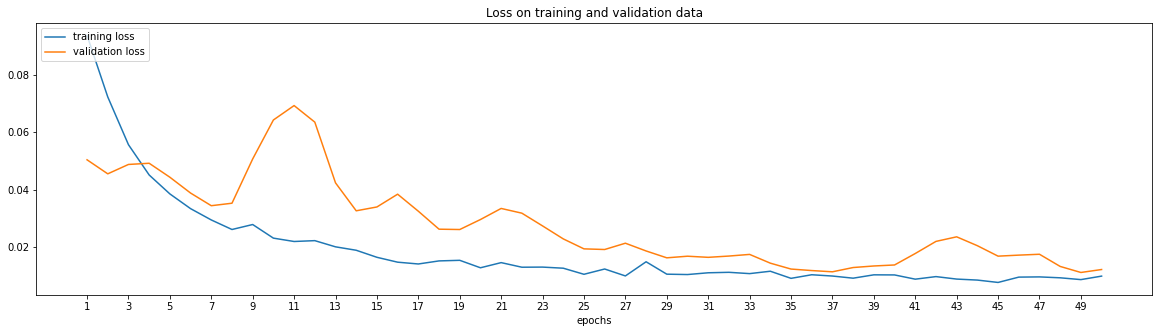

In [34]:
def plot_history(history_of_model):
    plt.figure(figsize = (20, 5))
    
    plt.subplot(1, 1, 1)
    plt.title('Loss on training and validation data')
    sns.lineplot(x = range(1, epochs + 1), y = history_of_model.history['loss'])
    sns.lineplot(x = range(1, epochs + 1), y = history_of_model.history['val_loss'])
    plt.xlabel('epochs')
    plt.xticks(list(range(1, epochs + 1))[::2])
    plt.legend(['training loss', 'validation loss'], loc = 'upper left')
    
    plt.show() 
    
plot_history(history_xception_fine)  

In [35]:
test_xception_loss = xception_fine.evaluate(x_test, y_test)
print(f'Loss on testing data with a Xception model: {test_xception_loss:0.4}')

3/3 [==============================] - 4s 832ms/step - loss: 0.0143
Loss on testing data with a Xception model: 0.01426


In [36]:
y_pred = (xception_fine.predict(x_test) * img_width).astype('int')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


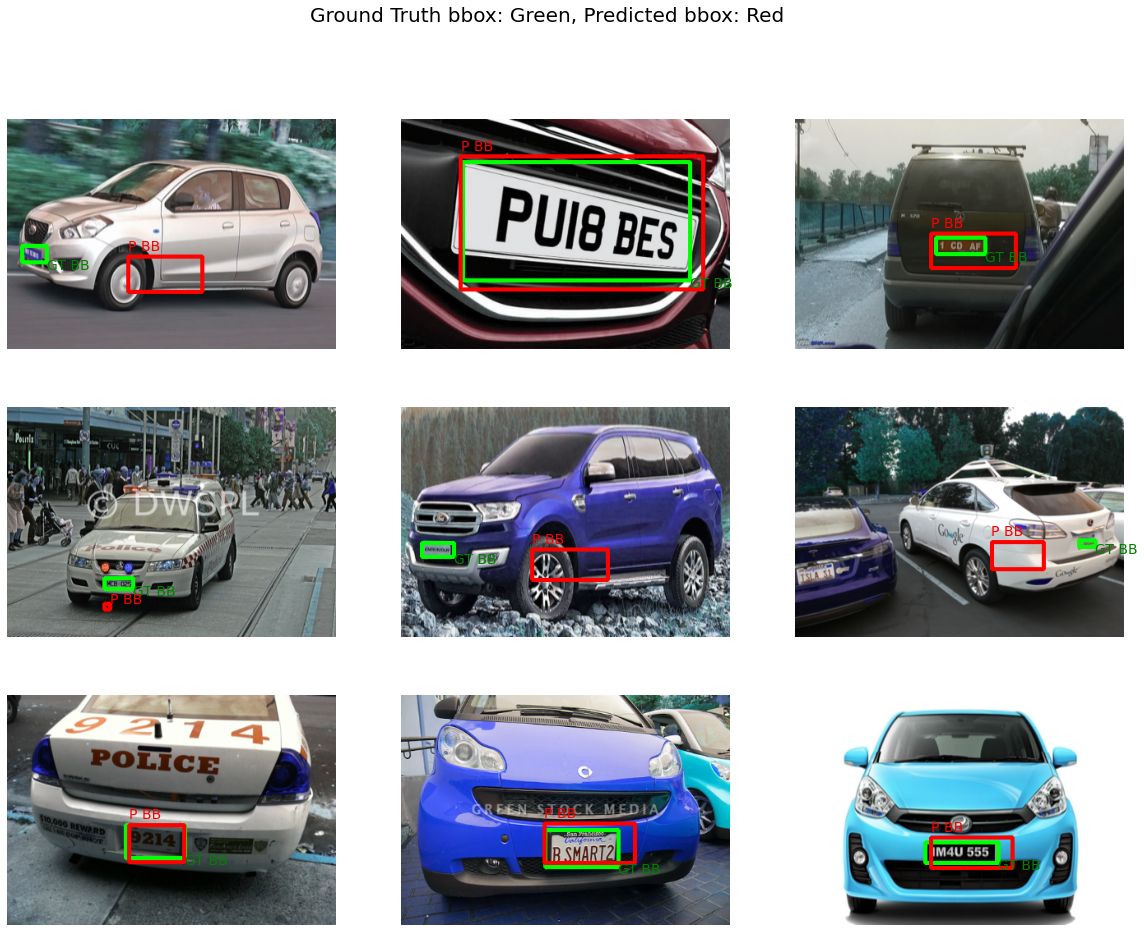

In [37]:
plt.figure(figsize = (20, 15))

for num, i in enumerate(np.random.randint(x_test.shape[0],size = 9)):
    
    plt.suptitle('Ground Truth bbox: Green, Predicted bbox: Red', size = 20)
   
    plt.subplot(3, 3, num + 1)
    cv2.rectangle(
        x_test[i], #image
        (int(y_test[i][0] * img_width), int(y_test[i][1] * img_width)), #start_point
        (int(y_test[i][2] * img_width), int(y_test[i][3] * img_width)), #end_point
        (0, 255, 0), #color: green
        3 #thickness
    )
    plt.text(
        int(y_test[i][0] * img_width),
        int(y_test[i][1] * img_width) + 8,
        'GT BB',
        fontsize = 14,
        color = 'g'
    )
    
    cv2.rectangle(
        x_test[i], #image
        (y_pred[i][0], y_pred[i][1]), #start_point
        (y_pred[i][2], y_pred[i][3]), #end_point
        (255, 0, 0), #color: red
        3 #thickness
    )
    plt.text(
        y_pred[i][2],
        y_pred[i][3] - 8,
        'P BB',
        fontsize = 14,
        color = 'r'
    )    
    
    plt.imshow(x_test[i])
    plt.axis('off')

# Conclusions <a id = '5'></a>

From the plots above, it is clear that this model does not recognize license plates well. Finding metrics and losses is currently one of the biggest challenges. Yolo must be used in the next step!

# References <a id = '6'></a>

- <a href = 'https://www.kaggle.com/code/mclikmb4/vehicle-license-plate-detection-vgg16'>Vehicle License Plate Detection | VGG16</a>